In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install mne
import mne
import os
import re
import numpy as np
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", message="This filename (.*) does not conform to MNE naming conventions.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 16.2 MB/s eta 0:00:00


In [ ]:
def remove_numbers(name):
    parts = name.split('_')
    class_name = parts[1]
    return class_name

def get_folder(name):
    parts = name.split('_')
    folder = parts[0]
    return folder

def read_eeg_data(file_path, folder):
    raw = mne.io.read_raw_fif(file_path, preload=True, verbose = 40)

    include_channels = ["O1", "O2", "P3", "P4", "C3", "C4", "F3", "F4"]
    # include_channels = ["F3", "F4", "C3", "C4"]
    raw.pick(picks=[ch for ch in raw.ch_names if ch in include_channels])
    raw.filter(1, 100, verbose = 40)
    raw.savgol_filter(15, verbose=40)
    data_segments = raw.get_data()
    # plot_trimmed_data(data_segments, raw.info['sfreq'], include_channels)

    if data_segments.shape[1] >= 1225:
        data_segments = data_segments[:, :1225]

    elif data_segments.shape[1] < 1225:
        raise ValueError("The data does not have enough time points. Required: 1225, Found: {}".format(data_segments.shape[1]))

    return data_segments

def plot_trimmed_data(data_segments, sfreq, channel_names):

    times = np.linspace(0, data_segments.shape[1] / sfreq, num=data_segments.shape[1])

    plt.figure(figsize=(12, 6))
    for i in range(data_segments.shape[0]):
        plt.plot(times, data_segments[i] + i * 30)
    plt.xlabel('Laikas (sek.)')
    plt.yticks(np.arange(0, data_segments.shape[0] * 30, 30), channel_names)

    plt.show()


In [ ]:
data = []
labels = []
folders = []
folder_path = '/content/drive/MyDrive/newDataWithSeperation'


for file in os.listdir(folder_path):
    if file.endswith('.fif'):
        file_path = os.path.join(folder_path, file)
        try:
            label = remove_numbers(os.path.splitext(file)[0])
            folder = get_folder(os.path.splitext(file)[0])
            eeg_data = read_eeg_data(file_path, folder)

            folder = get_folder(os.path.splitext(file)[0])

            data.append(eeg_data)
            labels.append(label)
            folders.append(folder)

        except ValueError as e:
            print(f"Skipping file {file}: {e}")

data = np.array(data)
labels = np.array(labels)
folders = np.array(folders)
print(data.shape)

(320, 8, 1225)


In [ ]:
def augment_data_by_reversing(data_segments, labels, folders):
    channels = ["O1", "O2", "P3", "P4", "C3", "C4", "F3", "F4"]
    for segment, label, folder in zip(data_segments, labels, folders):
        augmented_data_segments.append(segment)
        augmented_labels.append(label)
        augmented_folders.append(folder)

        reversed_segment = segment[:, ::-1]

        augmented_data_segments.append(reversed_segment)
        augmented_labels.append(label)
        augmented_folders.append(folder)

    return augmented_data_segments, augmented_labels

augmented_data_segments = []
augmented_labels = []
augmented_folders = []
augment_data_by_reversing(data, labels, folders)

data = np.array(augmented_data_segments)
labels = np.array(augmented_labels)
folders = np.array(augmented_folders)
print(data.shape)
print(labels.shape)
print(folders.shape)


(640, 8, 1225)
(640,)
(640,)


In [ ]:
!pip install tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Input, Conv1D, ReLU, Flatten, Dense

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

df = pd.DataFrame({
    'labels': labels,
    'folder': folders
})

encoder = LabelEncoder()
df['labels_encoded'] = encoder.fit_transform(df['labels'])

test_folders = ['1', '2']
mask = df['folder'].isin(test_folders)

X_train = data[~mask]
y_train = df.loc[~mask, 'labels_encoded']
X_test = data[mask]
y_test = df.loc[mask, 'labels_encoded']

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)

Training set size: (480, 8, 1225)
Testing set size: (160, 8, 1225)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Conv1D, ReLU, Flatten, Dense
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical

y_train_encoded = to_categorical(y_train, num_classes=4)
y_test_encoded = to_categorical(y_test, num_classes=4)

num_channels = X_train.shape[1]
num_time_points = X_train.shape[2]

model = Sequential()

model.add(Conv1D(filters=20, kernel_size=40, strides=2, padding='same', activation='relu', input_shape=(num_time_points, num_channels)))
model.add(Conv1D(filters=10, kernel_size=20, strides=1, padding='same', activation='relu'))
model.add(Flatten())
model.add(Dense(4, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

X_train = X_train.reshape([-1, 1225, num_channels])
X_test = X_test.reshape([-1, 1225, num_channels])

checkpoint_filepath = '/tmp/checkpoint_epoch_{epoch:02d}'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    save_freq='epoch')

history = model.fit(X_train, y_train_encoded, epochs=25, batch_size=50, validation_data=(X_test, y_test_encoded), callbacks=[model_checkpoint_callback])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 613, 20)           6420      
                                                                 
 conv1d_1 (Conv1D)           (None, 613, 10)           4010      
                                                                 
 flatten (Flatten)           (None, 6130)              0         
                                                                 
 dense (Dense)               (None, 4)                 24524     
                                                                 
Total params: 34954 (136.54 KB)
Trainable params: 34954 (136.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/25
10/10 [==============================] - 8s 340ms/step - loss: 13.6795 - accuracy: 0.2896 - val_loss: 2.7131 - val_accuracy: 0.2313
Epoch 2

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

y_train_encoded = to_categorical(y_train, num_classes=4)
y_test_encoded = to_categorical(y_test, num_classes=4)

num_channels = X_train.shape[1]
num_time_points = X_train.shape[2]

model = Sequential([
    Conv1D(filters=130, kernel_size=32, strides=1, padding='valid', activation='relu', input_shape=(num_time_points, num_channels)),
    Flatten(),
    Dense(152, activation='relu'),
    Dense(150, activation='relu'),
    Dense(4, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

X_train = X_train.reshape([-1, 1225, num_channels])
X_test = X_test.reshape([-1, 1225, num_channels])

checkpoint_filepath = '/tmp/checkpoint_epoch_{epoch:02d}'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    save_freq='epoch')

history = model.fit(X_train, y_train_encoded, epochs=25, batch_size=50, validation_data=(X_test, y_test_encoded), callbacks=[model_checkpoint_callback])



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 1194, 130)         33410     
                                                                 
 flatten_2 (Flatten)         (None, 155220)            0         
                                                                 
 dense_4 (Dense)             (None, 152)               23593592  
                                                                 
 dense_5 (Dense)             (None, 150)               22950     
                                                                 
 dense_6 (Dense)             (None, 4)                 604       
                                                                 
Total params: 23650556 (90.22 MB)
Trainable params: 23650556 (90.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/25
1

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, MaxPooling2D, Conv2D
from tensorflow.keras.utils import to_categorical

y_train_encoded = to_categorical(y_train, num_classes=4)
y_test_encoded = to_categorical(y_test, num_classes=4)

num_channels = X_train.shape[1]
num_time_points = X_train.shape[2]

model = Sequential([
    Conv2D(filters=60, kernel_size=(4, 4), activation='relu', strides=(1, 1), padding='same', input_shape=(num_time_points, num_channels, 1)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(filters=50, kernel_size=(4, 4), activation='relu', strides=(1, 1), padding='same'),
    MaxPooling2D(pool_size=(2, 1)),

    Conv2D(filters=40, kernel_size=(10, 10), activation='relu', strides=(1, 1), padding='same'),
    MaxPooling2D(pool_size=(2, 1)),

    Conv2D(filters=40, kernel_size=(10, 10), activation='relu', strides=(1, 1), padding='same'),
    MaxPooling2D(pool_size=(2, 1)),

    Conv2D(filters=4, kernel_size=(15, 15), activation='relu', strides=(1, 1), padding='same'),
    MaxPooling2D(pool_size=(2, 1)),

    Flatten(),
    Dense(50, activation='tanh'),
    Dense(20, activation='tanh'),
    Dense(4, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

X_train = X_train.reshape([-1, num_time_points, num_channels, 1])
X_test = X_test.reshape([-1, num_time_points, num_channels, 1])

checkpoint_filepath = '/tmp/checkpoint_epoch_{epoch:02d}'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    save_freq='epoch')

history = model.fit(X_train, y_train_encoded, epochs=25, batch_size=50, validation_data=(X_test, y_test_encoded), callbacks=[model_checkpoint_callback])

Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_210 (Conv2D)         (None, 1225, 4, 60)       1020      
                                                                 
 max_pooling2d_210 (MaxPool  (None, 612, 2, 60)        0         
 ing2D)                                                          
                                                                 
 conv2d_211 (Conv2D)         (None, 612, 2, 50)        48050     
                                                                 
 max_pooling2d_211 (MaxPool  (None, 306, 2, 50)        0         
 ing2D)                                                          
                                                                 
 conv2d_212 (Conv2D)         (None, 306, 2, 40)        200040    
                                                                 
 max_pooling2d_212 (MaxPool  (None, 153, 2, 40)      

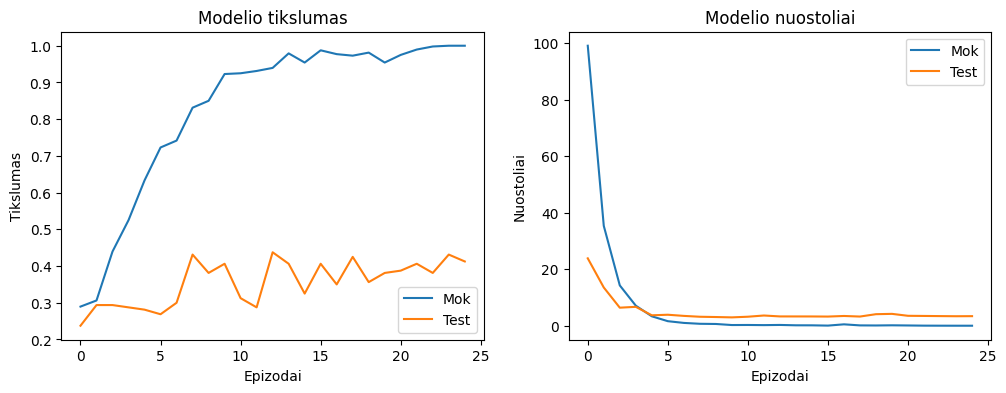

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Modelio tikslumas')
plt.ylabel('Tikslumas')
plt.xlabel('Epizodai')
plt.legend(['Mok', 'Test'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Modelio nuostoliai')
plt.ylabel('Nuostoliai')
plt.xlabel('Epizodai')
plt.legend(['Mok', 'Test'], loc='upper right')

plt.show()

5/5 [==============================] - 1s 94ms/step


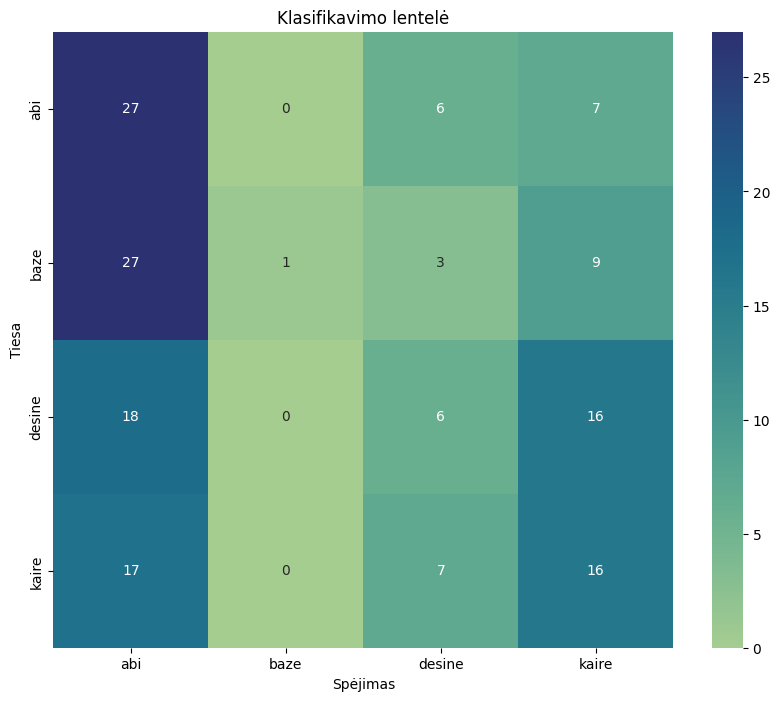

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

epoch_to_load = 11
model.load_weights(f'/tmp/checkpoint_epoch_{epoch_to_load:02d}')

predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

for data_point, predicted_class in zip(X_test, predicted_classes):
    data_point.reshape([-1, 1, 1225])

cm = confusion_matrix(y_test, predicted_classes)

labels_true = encoder.inverse_transform(range(len(encoder.classes_)))

labels_true = [label.replace("Baseline", "Jokio").replace("Desine", "Dešinė") for label in labels_true]

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels_true, yticklabels=labels_true, cmap="crest")
plt.xlabel('Spėjimas')
plt.ylabel('Tiesa')
plt.title('Klasifikavimo lentelė')
plt.show()

